In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Embedding, add
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
import numpy as np
from tqdm.notebook import tqdm
import pickle

feature extraction from Images

In [2]:
DATASET_DIR = './dataset/'
IMAGE_DIR = 'images/'
IMAGE_CAPTION_FILE = 'clean_caption_file.txt'
MODEL_DIR = './models/'

#### Create VGG16 Model for the feature extraction

In [3]:
vgg_model = VGG16()

vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

print(vgg_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### Create feature map dictionary that contains image file name as ID and its extracted features as a value

In [4]:
image_features = {}
image_dir = os.path.join(DATASET_DIR,IMAGE_DIR)

for image_file_name in tqdm(os.listdir(image_dir)):
    image_file = os.path.join(image_dir,image_file_name)
    
    #load image file
    image = load_img(image_file, target_size=(224,224))
    
    image = img_to_array(image)
    
    image = image.reshape((1, image.shape[0],image.shape[1],image.shape[2]))
    
    image = preprocess_input(image)
    
    img_feature = vgg_model.predict(image)
    
    image_id = image_file_name.split('.')[0]
    
    image_features[image_id] =img_feature

  0%|          | 0/1242 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


### Save VGG16 Model for future use

In [5]:
pickle.dump(image_features, open(os.path.join(MODEL_DIR,'vgg_features.pkl'), 'wb'))

### Load VGG16 model

In [6]:
with open(os.path.join(MODEL_DIR,'vgg_features.pkl'), 'rb') as file:
    image_features = pickle.load(file)

#### Find total image features

In [7]:
len(image_features)

1242

from the caption file map image_id to its caption or tags

80bbe2f8-917e-492d-af69-ad05edc156fd => ShirtStyleTop | HalfSleeves | ShirtCollar | RegularSleeves

first read caption file

In [8]:
image_file_tags = ""
with open(os.path.join(DATASET_DIR,IMAGE_CAPTION_FILE),'r') as tags_file:
    image_file_tags = tags_file.read()

In [9]:
image_to_tags_dict = {}

for line in tqdm(image_file_tags.split('\n')):
    #print(line)
    try:        
        image_file_name, image_tags = line.split(',')
        image_id = image_file_name.split('.')[0].strip()
        image_tags = image_tags.strip()
    
        image_to_tags_dict[image_id] = image_tags
    except:
        print(line)

  0%|          | 0/1243 [00:00<?, ?it/s]

#### Before precedding caption data, first preserve the original data for the later use.

This code create map of the all unique tags for the final output to the user interface as processed tags by RNN changes the text to lowercase and remove digits

In [10]:
#all_original_tags = []
unique_tag_dic = {}

for img_id, tag_line in image_to_tags_dict.items():    
    tag_line = tag_line.strip()
    tag_line = tag_line.split('|')
    for tag in tag_line:
        tag_val = tag.replace('3/4th',"ThreeFourth")
        tag_val = tag_val.replace('-','')
        tag_key = tag_val.lower()
        unique_tag_dic[tag_key] = tag_val 
   
unique_tag_dic['start'] = "Start"
unique_tag_dic['end'] = "End"
unique_tag_dic

{'shirtstyletop': 'ShirtStyleTop',
 'halfsleeves': 'HalfSleeves',
 'shirtcollar': 'ShirtCollar',
 'regularsleeves': 'RegularSleeves',
 'empiretop': 'EmpireTop',
 'threefourthsleeves': 'ThreeFourthSleeves',
 'roundneck': 'RoundNeck',
 'regulartop': 'RegularTop',
 'fullsleeves': 'FullSleeves',
 'uneck': 'UNeck',
 'knotfronttop': 'KnotFrontTop',
 'peterpancollar': 'PeterPanCollar',
 'flaredsleeves': 'FlaredSleeves',
 'croptop': 'CropTop',
 'highneck': 'HighNeck',
 'rufflesleeves': 'RuffleSleeves',
 'drawstringtop': 'DrawstringTop',
 'capsleeves': 'CapSleeves',
 'vneck': 'VNeck',
 'tieupneck': 'TieUpNeck',
 'boatneck': 'BoatNeck',
 'squareneck': 'SquareNeck',
 'puffsleeves': 'PuffSleeves',
 'ruffledneck': 'RuffledNeck',
 'sleeveless': 'Sleeveless',
 'shoulderstraps': 'ShoulderStraps',
 'chokerneck': 'ChokerNeck',
 'tunic': 'Tunic',
 'peplumtop': 'PeplumTop',
 'mandarincollar': 'MandarinCollar',
 'rollupsleeves': 'RollupSleeves',
 'regulartops': 'RegularTops',
 'alinetop': 'ALineTop',
 'key

#### Start processing captions text for the RNN or LSTM algorithm

Preprocess the data

1) Convert to lower case

2) remove | from the captions

3) replace digits and special characters

4) mark "start" and "end" to recognize the string for the output

In [11]:
all_tags = []

def data_cleaning(image_tag_dict):
    for img_id,tag_line in image_tag_dict.items():        
        tag_line = tag_line.strip()
        tag_line = tag_line.lower()
        tag_line = tag_line.replace('|',' ')
        tag_line = tag_line.replace('3/4th', 'threefourth')
        tag_line = tag_line.replace('-','')
        tag_line = '<start> ' + tag_line + ' <end>'
        image_to_tags_dict[img_id] = tag_line
        all_tags.append(tag_line)

In [12]:
data_cleaning(image_tag_dict=image_to_tags_dict)

In [13]:
image_to_tags_dict

{'80bbe2f8-917e-492d-af69-ad05edc156fd': '<start> shirtstyletop halfsleeves shirtcollar regularsleeves <end>',
 '79a88cfb-ac8a-4298-8024-ab4a9ef8f666': '<start> empiretop threefourthsleeves roundneck regularsleeves <end>',
 '7a47a00e-8220-40e3-a92e-5a0dc30ea9cd': '<start> regulartop fullsleeves uneck <end>',
 'cddd97d1-735f-4c41-9b15-6878d075e91e': '<start> regulartop threefourthsleeves roundneck regularsleeves <end>',
 '25c13e86-4c5d-42fc-a040-409dc0a1412b': '<start> knotfronttop halfsleeves peterpancollar flaredsleeves <end>',
 '01b0c8ac-ea3d-4a99-8397-fd1b1cd50091': '<start> regulartop fullsleeves roundneck regularsleeves <end>',
 'fd4a5f6e-717d-4aa2-b94d-628952549d91': '<start> croptop halfsleeves highneck regularsleeves <end>',
 'de77e6c0-a8f4-488f-9bd3-590fba685278': '<start> regulartop halfsleeves roundneck rufflesleeves <end>',
 'ea68a9d5-a382-4a83-80c4-8f6daaaf5eda': '<start> empiretop threefourthsleeves roundneck regularsleeves <end>',
 '3316a5ec-1c0d-4683-9238-d6dac60bd2ec':

Calculate how many tags

In [14]:
len(all_tags)

1242

Tokenize all tags and find unique vocabulary size

In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_tags)        
word_index = tokenizer.word_index
print(word_index)
vocab_size = len(word_index) + 1
print(vocab_size)

{'start': 1, 'end': 2, 'roundneck': 3, 'threefourthsleeves': 4, 'regulartop': 5, 'regulartops': 6, 'fullsleeves': 7, 'regularsleeves': 8, 'halfsleeves': 9, 'sleeveless': 10, 'croptop': 11, 'vneck': 12, 'croptops': 13, 'empiretop': 14, 'capsleeves': 15, 'highneck': 16, 'offshoulder': 17, 'mandarincollar': 18, 'shirtcollar': 19, 'shirtstyletop': 20, 'boatneck': 21, 'coldshoulder': 22, 'alinetop': 23, 'tieupneck': 24, 'tunic': 25, 'puffsleeves': 26, 'shoulderstraps': 27, 'bellsleeves': 28, 'flaredsleeves': 29, 'tunics': 30, 'sweetheartneck': 31, 'uneck': 32, 'chinesecollar': 33, 'knotfronttop': 34, 'squareneck': 35, 'asymmetricaltop': 36, 'tanktops': 37, 'ruffledneck': 38, 'keyholeneck': 39, 'drawstringtop': 40, 'extendedsleeves': 41, 'peplumtop': 42, 'kimonosleeves': 43, 'oneshoulder': 44, 'halterneck': 45, 'tanktop': 46, 'chokerneck': 47, 'cinchedwaisttop': 48, 'wraptop': 49, 'boxy': 50, 'peterpancollar': 51, 'rufflesleeves': 52, 'rollupsleeve': 53, 'camisoletop': 54, 'hooded': 55, 'kaf

find maximum length from all tags

In [16]:
max_length = max(len(tag.split()) for tag in all_tags)
max_length

7

#### Train Test Split (90 - 10)

In [17]:
image_ids = list(image_to_tags_dict.keys())

train_test_split_number = int(len(image_ids) * 0.90)

train_data = image_ids[:train_test_split_number]
test_data = image_ids[train_test_split_number:]

In [18]:
print("Training size: ",len(train_data))
print("Testing size: ",len(test_data))

Training size:  1117
Testing size:  125


#### Generate features and target data in a batch based on token and extracted image features

1) Convert each caption according to tokenized sequence

2) Do padding based on maximum length

3) Convert label into categorical data

4) return above processed data as a feature X and label Y

In [19]:
def model_feature_generator(image_list, image_to_tags_dict,image_features_mapping, tokenizer, max_length, vocab_size, batch_size):
    X_image_feature, X_tag_feature, y_categorical_label = list(), list(), list()
    batch_counter = 0
    while 1:
        for key in image_list:
            batch_counter += 1
            #print(key)
            caption = image_to_tags_dict[key]
            
            seq = tokenizer.texts_to_sequences([caption])[0]
            
            for ind in range(1,len(seq)):
                input_seq, output_seq = seq[:ind], seq[ind]
                input_seq = pad_sequences([input_seq], maxlen=max_length)[0]
                output_seq = to_categorical([output_seq], num_classes=vocab_size)[0]
                X_image_feature.append(image_features_mapping[key][0])
                X_tag_feature.append(input_seq)
                y_categorical_label.append(output_seq)     
            
            if batch_counter == batch_size:
                X_image_feature, X_tag_feature, y_categorical_label = np.array(X_image_feature), np.array(X_tag_feature), np.array(y_categorical_label)
                yield [X_image_feature, X_tag_feature], y_categorical_label
                X_image_feature, X_tag_feature, y_categorical_label = list(), list(), list()                 
                batch_counter = 0

#### Create Decoder model by adding image features and tokenized enoder models

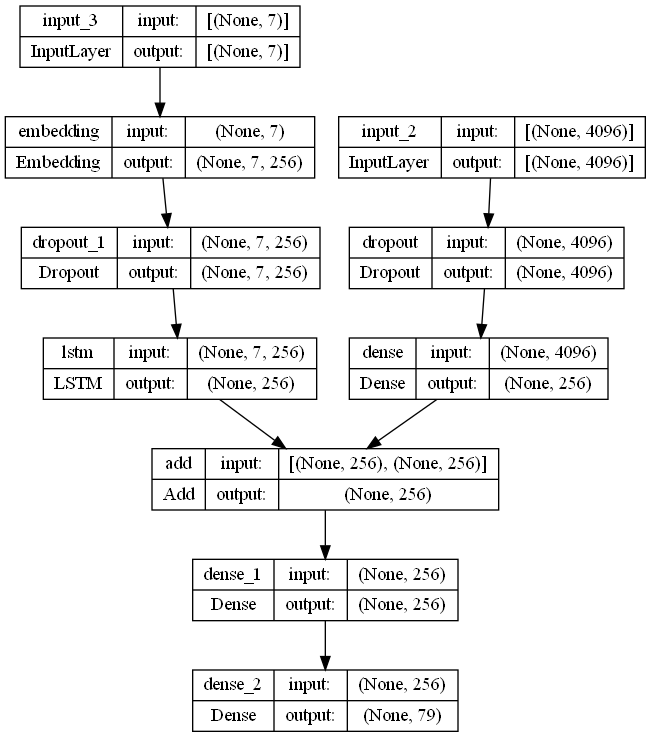

In [20]:
image_inputs = Input(shape=(4096,))
img_feature_ex1 = Dropout(0.4)(image_inputs)
img_feature_ex2 = Dense(256, activation='relu')(img_feature_ex1)

tag_seq_inputs = Input(shape=(max_length,))
seq_extr1 = Embedding(vocab_size,256,mask_zero=True)(tag_seq_inputs)
seq_extr2 = Dropout(0.4)(seq_extr1)
seq_extr3 = LSTM(256)(seq_extr2)

decoder1 = add([img_feature_ex2,seq_extr3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[image_inputs,tag_seq_inputs], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

plot_model(model, show_shapes=True)

#### Train the model on batch

In [21]:
epochs = 20
batch_size = 32
steps = len(train_data) // batch_size


for i in range(epochs):
    # create model features
    generator = model_feature_generator(train_data,
                image_to_tags_dict=image_to_tags_dict,
                image_features_mapping=image_features,
                tokenizer=tokenizer,
                max_length=max_length,
                vocab_size=vocab_size,
                batch_size=batch_size)
    # fit for one epoch
    history = model.fit(generator, epochs=2, steps_per_epoch=steps, verbose=1,)

Epoch 1/2
34/34 [==============================] - 5s 31ms/step - loss: 3.0479 - accuracy: 0.2234
Epoch 2/2
34/34 [==============================] - 1s 31ms/step - loss: 2.0840 - accuracy: 0.4755
Epoch 1/2
34/34 [==============================] - 1s 32ms/step - loss: 1.5485 - accuracy: 0.5675
Epoch 2/2
34/34 [==============================] - 1s 30ms/step - loss: 1.3109 - accuracy: 0.6016
Epoch 1/2
34/34 [==============================] - 1s 31ms/step - loss: 1.1568 - accuracy: 0.6429
Epoch 2/2
34/34 [==============================] - 1s 30ms/step - loss: 1.0508 - accuracy: 0.6685
Epoch 1/2
34/34 [==============================] - 1s 30ms/step - loss: 0.9709 - accuracy: 0.6831
Epoch 2/2
34/34 [==============================] - 1s 30ms/step - loss: 0.8997 - accuracy: 0.7043
Epoch 1/2
34/34 [==============================] - 1s 29ms/step - loss: 0.8328 - accuracy: 0.7177
Epoch 2/2
34/34 [==============================] - 1s 31ms/step - loss: 0.7766 - accuracy: 0.7427
Epoch 1/2
34/34 [===

### Save final model for future use

In [22]:
model.save(os.path.join(MODEL_DIR,'tag_generation_model.h5'))

#### Perform untokenization, this will reverse the process from tokenized data to text data

In [23]:
def get_word_from_tokenized_data(index, tokenizer):
    for word, indx in tokenizer.word_index.items():
        if indx == index:
            return word
    return None

#### Predict Tags or captions for the given image (image in the form of matrix)

In [24]:
def predict_tags(model, image, tokenizer, max_length):
    
    #print(image)
    
    in_text = '<start>'
    
    for ind in range(max_length):
        
        seq = tokenizer.texts_to_sequences([in_text])[0]
        
        seq = pad_sequences([seq], max_length)
        
        y_hat = model.predict([image, seq], verbose=0)
        
        y_hat = np.argmax(y_hat)
        
        word = get_word_from_tokenized_data(y_hat, tokenizer)
        
        if word is None:
            break
        
        in_text += " " + word
        
        if word == '<end>':
            break
    
    return in_text

### Validate data using BLEU Score

BLEU (Bilingual Evaluation Understudy) is a measurement of the difference 
between an automatic translation and human-created reference translations of the same source sentence.

We will be using sentence_bleu() method for the actual and predicted tags,
and performing 4gm validation with each 0.25 value.

Low Score is less than 0.4, and High Score is greater than 0.4

LOW SCORE < 0.4

GOOD SCORE > 0.4

Result: The model predict only one record less than 0.4 score and performing well on test data

In [25]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

actual, predicted = list(), list()
bleu_score_list = list()

for img_key in tqdm(test_data):
    
    
    #get actual caption
    captions = image_to_tags_dict[img_key]
    captions = captions.strip()
    captions = captions.replace("<start>",'')
    captions = captions.replace("<end>",'')
    
    y_pred = predict_tags(model,image_features[img_key], tokenizer, max_length  )
    y_pred = y_pred.strip()
    y_pred = y_pred.replace('<start>','')
    y_pred = y_pred.replace('end','')
   
    actual.append(captions)
    predicted.append(y_pred)        

    BLEU1 = sentence_bleu(actual,y_pred, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=SmoothingFunction().method7)
    
    bleu_score_list.append(BLEU1)
            
    
total_min_bleu_score = 0
for ind in bleu_score_list:
    if ind < 0.4:        
        total_min_bleu_score +=1

#print(np.max(bleu_1), np.min(bleu_1))
print("Max BLEU Score: {}, Min BLEU Score: {}, Total Min BLEU Score: {}".format(np.max(bleu_score_list), np.min(bleu_score_list), total_min_bleu_score ))

  0%|          | 0/125 [00:00<?, ?it/s]

Max BLEU Score: 1.0809839097082343, Min BLEU Score: 0.39657714323871396, Total Min BLEU Score: 1


#### Convert raw tags to original tags for the UI

first find the Captial letter and replace space before letter

ThreeFourthSleeves ====> Three Fourth Sleeves

In [26]:
def get_original_tag_value(tokened_tag):
    # first find the Captial letter and replace space before letter
    # ThreeFourthSleeves ====> Three Fourth Sleeves
    caps = [pos for pos, c in enumerate(tokened_tag) if c.isupper()  ]
    caps.remove(0)
    original_tag = tokened_tag
    for pos, ind in enumerate(caps):    
        original_tag = original_tag.replace(original_tag[ind + pos], ' ' + original_tag[ind +pos])
    
    return original_tag

#### Generate Captions for the given image by prediction

In [27]:
def generate_caption(image):

    y_pred = predict_tags(model, image, tokenizer,max_length)
    
    print("=======================")
    print("Tags predicted from Model")
    print(y_pred)
    print("=======================")
    
    prod_tag_list = y_pred.replace("<start>",'')
    prod_tag_list = prod_tag_list.replace("end",'')
    prod_tag_list = prod_tag_list.strip()
    prod_tag_list = prod_tag_list.split(" ")
    product_tags = []
    for ptag in prod_tag_list:   
        if ptag in unique_tag_dic:
            product_tags.append(unique_tag_dic[ptag])  
            
    product_tags = list(dict.fromkeys(product_tags))      
    
    original_prod_list = [get_original_tag_value(prodtag) for prodtag in product_tags]
    
    return original_prod_list

#### Convert uploaded image into VGG16 feature for the Tag prediction

In [28]:
def set_test_image_feature(image_path):
    #load image file
    image = load_img(image_path, target_size=(224,224))
    
    image = img_to_array(image)
    
    image = image.reshape((1, image.shape[0],image.shape[1],image.shape[2]))
    
    image = preprocess_input(image)
    
    img_feature = vgg_model.predict(image)
    
    image_id = image_file_name.split('.')[0]
    
    #image_features[image_id] = img_feature
    
    return img_feature
    

#### Generic function for the Tag prediction of the uploaded UI.

### This method directly used by the REST API layer to retrive possible Tags of the uploaded image

In [29]:
def generate_image_tag(image_path):    
    image_feat = set_test_image_feature(image_path)
    tags = generate_caption(image_feat)
    return tags

# REST Layer

In [30]:
from flask import Flask
from flask import jsonify, request
from werkzeug.utils import secure_filename
from flask_cors import CORS

In [32]:
app = Flask(__name__)
UPLOAD_FOLDER = './uploaded_images/'
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER
CORS(app)

ALLOWED_EXTENSIONS = set(['txt', 'pdf', 'png', 'jpg', 'jpeg', 'gif'])

def allowed_file(filename):    
	return '.' in filename and filename.rsplit('.', 1)[1].lower() in ALLOWED_EXTENSIONS

def predict_image_tags(img_file_name):
    img_file = './uploaded_images/' + img_file_name
    image_tags = generate_image_tag(img_file)
    #image_tags = generate_caption(img_file_name)
    #image_tags = tag_gen_model.generate_image_tag(img_file,img_file_name)
    return image_tags

@app.route('/upload', methods=['POST'])
def example():
    resp_message = {}    
    
    if 'file' not in request.files:
        resp_message['message'] = 'No file part in the request'
        resp = jsonify(resp_message)
        resp.status_code = 400
        return resp
    
    file = request.files['file']
    
    if file.filename == '':
        resp_message['message'] = 'No file selected for uploading'
        resp = jsonify(resp_message)
        resp.status_code = 400
        return resp
    
    if file and allowed_file(file.filename):    
        filename = secure_filename(file.filename)
        file.save(os.path.join(app.config['UPLOAD_FOLDER'], filename)) 
        image_tags = predict_image_tags(filename)
        resp_message['message'] = image_tags  
        resp = jsonify(resp_message) 
        resp.status_code = 200
        return resp
    else:
        resp_message['message'] = 'Only image file types are allowed (jpg, jpeg, png)'  
        resp = jsonify(resp_message)
        resp.status_code = 400
        return resp

if __name__ == "__main__":
    app.run()

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


1/1 [==============================] - 0s 35ms/step


127.0.0.1 - - [02/Dec/2022 21:02:49] "POST /upload HTTP/1.1" 200 -


Tags predicted from Model
<start> croptop fullsleeves vneck regularsleeves end end end
1/1 [==============================] - 0s 36ms/step


127.0.0.1 - - [02/Dec/2022 21:03:07] "POST /upload HTTP/1.1" 200 -


Tags predicted from Model
<start> regulartop sleeveless roundneck end end end end
1/1 [==============================] - 0s 46ms/step


127.0.0.1 - - [02/Dec/2022 21:03:19] "POST /upload HTTP/1.1" 200 -


Tags predicted from Model
<start> croptop capsleeves roundneck end end end end
1/1 [==============================] - 0s 27ms/step


127.0.0.1 - - [02/Dec/2022 21:03:33] "POST /upload HTTP/1.1" 200 -


Tags predicted from Model
<start> regulartop threefourthsleeves offshoulder regularsleeves end end end
